In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from vqvae import *
from hyper_params import *
import json
from vqvae_train import *

def load_configurations():
    with open('config_vqvae.json', 'r') as f:
        configurations = json.load(f)
    return configurations

config = load_configurations()
print(config)

vqvae_hp = vqvae_hyperparams()

vqvae = VQVAE(
    in_channel=vqvae_hp['in_channel'],
    channel=vqvae_hp['channel'],
    n_res_block=vqvae_hp['n_res_block'],
    n_res_channel=vqvae_hp['n_res_channel'],
    embed_dim=vqvae_hp['embed_dim'],
    n_embed=vqvae_hp['n_embed'],
    decay=vqvae_hp['decay'],
    n_dims=vqvae_hp['n_dims'],
    has_transformer=config['has_transformer'],
    n_trans_layers=vqvae_hp['n_trans_layers']
)

x = torch.randn(10, 2, 640)

y = select_samples(x, 4)

plt_two_time_series(y, ".", vqvae, -1)

In [ ]:
import wfdb
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

record = wfdb.rdrecord('100', pn_dir='mitdb')
annotations = wfdb.rdann('100', 'atr', pn_dir='mitdb')

In [ ]:
patient_records = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                    '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                    '222', '223', '228', '230', '231', '232', '233', '234']

for rec in patient_records:
    record = wfdb.rdrecord(rec, pn_dir='mitdb')
    signals = record.p_signal
    print(rec, signals.shape)

In [ ]:
import wfdb

# Load the annotations for a specific patient record


# Display the types of annotations (arrhythmias)
print(annotations.symbol)

# Optionally, count occurrences of each type of arrhythmia
from collections import Counter
arrhythmia_counts = Counter(annotations.symbol)
print(arrhythmia_counts)


In [ ]:
import matplotlib.pyplot as plt

# Assuming 'record' is already loaded and contains the ECG data
channel_1 = record.p_signal[:,0]

# Generate time values based on the sampling rate, assumed to be 360 Hz
time = [i / 360 for i in range(1028)]  # generates time in seconds

# Plotting the first 1028 points
plt.figure(figsize=(10, 4))
plt.plot(time, channel_1[:1028], label='Channel 1')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal of Channel 1')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
from prepare_mitbih import *

mitbih_dataset = MITBIHDataProcessor('mitdb')
mitbih_dataset.load_patients_data()
X_train_data = mitbih_dataset.prepare_model_input('Train')
print(X_train_data.shape)

Begin retrieving data for patients: 2024-04-28 23:00:50
Finish retrieving data for patients: 2024-04-28 23:02:39
Begin preparing model input for Train: 2024-04-28 23:02:39
Finish preparing model input for Train: 2024-04-28 23:02:39
torch.Size([3300, 2, 1080])


cuda
Number of parameters in the model: 3779462


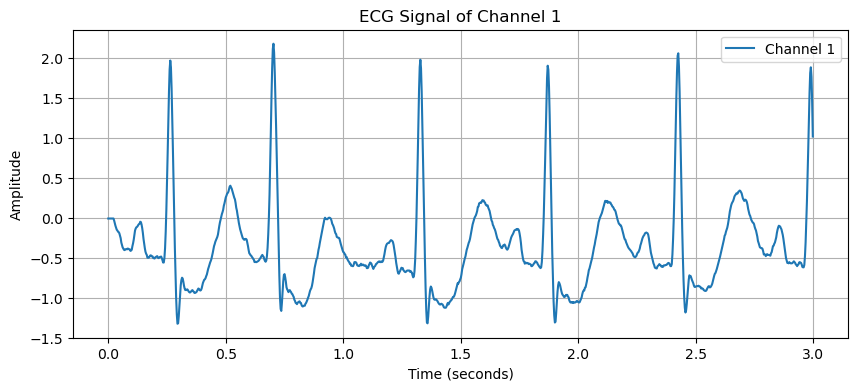

In [4]:
import os
import matplotlib as mpl
import torch
from torch.utils.data import DataLoader
from torch.nn import DataParallel
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime
import json

# Local imports
import sys
from hyper_params import *
from preprocess_data import *
from vqvae import *
from training import *
from paths import *
from prepare_mitbih import *

# Configure GPU settings
os.environ['CUDA_DEVICE_ORDER'] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

vqvae_hp = vqvae_hyperparams()
vqvae = VQVAE(
    in_channel=vqvae_hp['in_channel'],
    channel=vqvae_hp['channel'],
    n_res_block=vqvae_hp['n_res_block'],
    n_res_channel=vqvae_hp['n_res_channel'],
    embed_dim=vqvae_hp['embed_dim'],
    n_embed=vqvae_hp['n_embed'],
    decay=vqvae_hp['decay'],
    n_dims=vqvae_hp['n_dims'],
    has_transformer=config['has_transformer'],
    n_trans_layers=vqvae_hp['n_trans_layers']
).to(device)
print(f"Number of parameters in the model: {sum(p.numel() for p in vqvae.parameters() if p.requires_grad)}")

optimizer = optim.RAdam(vqvae.parameters(), lr=vqvae_hp['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

def plt_two_time_series(samples, path, model, epoch):
    X_reconstructed = model(samples)[MODELS_TENSOR_PREDICITONS_KEY]

    for i in range(samples.shape[0]):
        fig, axs = plt.subplots(2, 1, figsize=(20, 10))  # Create 2 subplots for each channel
        
        for channel in range(2):
            orig = samples[i, channel, :].detach().cpu().numpy()  # Original signal for the channel
            pred = X_reconstructed[i, channel, :].detach().cpu().numpy()  # Reconstructed signal
            
            axs[channel].plot(orig, color='orange', label='Original')
            axs[channel].plot(pred, color='grey', label='Reconstructed')
            y_min = -2 if orig.min() > -1 else orig.min()-1
            y_max = 2 if orig.max() < 1 else orig.max()+1
            axs[channel].set_ylim([y_min, y_max])
            axs[channel].set_title(f'Channel {channel+1}: Original vs Reconstructed')
            axs[channel].set_xlabel('Time')
            axs[channel].set_ylabel('ECG')
            axs[channel].legend()
        
        plt.tight_layout()
        res_filename = path / f"before_training.png" if epoch == -1 else path / f"epoch_{epoch}_sample_{i}.png"
        plt.savefig(res_filename)
        plt.close()

# plt_two_time_series(data['100'][:1,:,:].to('cuda'), Path('results'), vqvae, -1)

# _sample_per_second = 360
# _input_signal_duration = config['input_signal_duration']
# _forecast_predictions_mitbih = config['forecast_predictions']
# _signals_per_patient_mitbih = config['signals_per_patient']
# _samples_per_patient = _signals_per_patient_mitbih*_input_signal_duration*_sample_per_second*_forecast_predictions_mitbih
# _forecast_signals = int(_sample_per_second * _input_signal_duration * _forecast_predictions_mitbih)

# timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# print("begin retrieving data for patients:", timestamp)

# try:
#     # Load ECG record
#     ecg_record = wfdb.rdrecord('100', pn_dir='mitdb', sampto=_samples_per_patient)
#     signal_array = ecg_record.p_signal
#     num_rows = _samples_per_patient // _forecast_signals
#     num_channels = 2  # Assuming there are always 2 channels

#     # Manually creating the tensor
#     tensor_segments = []
#     for i in range(num_rows):
#         start_index = i * _forecast_signals
#         end_index = start_index + _forecast_signals
#         segment = signal_array[start_index:end_index]
#         tensor_segments.append(torch.tensor(segment, dtype=torch.float32))

#     # Stacking segments to form the tensor with shape [rows, 2, self._forecast_signals]
#     test = torch.stack(tensor_segments).transpose(1, 2)
# except Exception as e:
#     print(f"Failed to load record {record}: {e}")

# timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# print("Finish retrieving data for patients:", timestamp)

# record = wfdb.rdrecord('100', pn_dir='mitdb', sampto=1080*10)
# ecg_record = wfdb.rdrecord('100', pn_dir='mitdb', sampto=1080*10)
# tensor = torch.tensor(ecg_record.p_signal.reshape(10,2,1080))
# print(sum(tensor[0,0,:1080] - ecg_record.p_signal[:1080,0]))
# time = [i / 360 for i in range(3*360)]  # generates time in seconds

data = torch.load(str(TEST_DATA))

time = [i / 360 for i in range(1080)]

# Plotting the first 1028 points
plt.figure(figsize=(10, 4))
plt.plot(time, data[0,0,:], label='Channel 1')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('ECG Signal of Channel 1')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
import numpy as np
import torch

# Let's simulate loading of your ECG data
# Random data generation for demonstration; replace this with your actual loading code
np.random.seed(0)
ecg_record = np.random.randn(2160, 2)  # Simulating 2160 samples, 2 channels, for simplicity

# Initial data integrity check
print("Original data samples [0:5]:\n", ecg_record[:5])

# Reshape operation
samples_per_row = 1080  # Number of samples per row
reshaped_data = ecg_record.reshape(-1, 2, samples_per_row)

# Convert to torch tensor
tensor = torch.tensor(reshaped_data, dtype=torch.float32)

# Compare the reshaped data
reshaped_back = tensor
print("Reshaped data samples [0:5]:\n", reshaped_back.reshape(-1, 2)[:5])

# Calculating differences
differences = np.abs(ecg_record - reshaped_back.reshape(-1, 2))
print("Sum of differences for the first 1080 samples:", np.sum(differences[:1080]))
